In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://NotShrirang:<GIT_PAT>@github.com/NotShrirang/GPT-From-Scratch.git

Cloning into 'GPT-From-Scratch'...
remote: Enumerating objects: 214, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 214 (delta 102), reused 149 (delta 54), pack-reused 0
Receiving objects: 100% (214/214), 7.11 MiB | 4.51 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [7]:
%cd "/content/GPT-From-Scratch"

/content/GPT-From-Scratch


In [5]:
!pip install -r "/content/GPT-From-Scratch/requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.9/996.9 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [8]:
!python /content/GPT-From-Scratch/scripts/inference_gpt.py

Loading tokenizer...
Loaded tokenizer from file /content/GPT-From-Scratch/config/shakespearean_config.json
Loading hyperparameters...

Loaded model on device `cuda`

Hyperparameters:
    batch_size: 32
    block_size: 256
    max_iters: 3000
    eval_interval: 300
    learning_rate: 3e-05
    eval_iters: 50
    n_embd: 384
    n_head: 6
    n_layer: 6
    dropout: 0.3
    vocab_size: 65


Loading model...

Model is of  10.788929 M parameters
Generating text...

Prompt:  Write a scene about ROMEO arguing with JULIET.
ROMEO: 
Thou unstand the way noting of wombs, but thou shoath
A fool and great Anne ward Deaths,
As thout rechised that restrainted to the king
The thought of the valour's charge in to
And pat-pard with and stockies with speech: but I have be
Thy mercy at guestering in thee
Than is shed by this.

BRUTUS:
Alt, the auntle very exocessions lost.

MENENIUS:
They will go have you boy, the mortall's in your house,
Afterhead him and heard you dishonour.

Both Sot:
Ay, sir, thou be

In [11]:
!head -n 5 /content/GPT-From-Scratch/data/input.txt

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [15]:
import json
import os
import sys
import torch
import tqdm
import argparse

current_dir = os.path.dirname(os.path.abspath("/content/"))
parent_dir = os.path.dirname(current_dir)

import core.utils.gptutils as gptutils
from core.models.gpt import GPTLanguageModel
from core.tokenizers.tokenizer import Tokenizer

# args = argparse.ArgumentParser()

# args.add_argument('--config_path', type=str, default='config/config.json',
#                     help='Path to the config file')

# args.add_argument('--data_path', type=str, default='data/corpus.txt',
#                     help='Path to the data file')

# args.add_argument('--name', type=str, default='GPT',
#                     help='Name of the model')

# args.add_argument('--output_dir', type=str, default='trained_models',
#                     help='Path to save the model')

# args = args.parse_args()

# config_path = args.config_path
# data_path = args.data_path
# name = args.name
# save_path = args.output_dir

config_path = "/content/GPT-From-Scratch/config/shakespearean_config.json"
data_path = "/content/GPT-From-Scratch/data/input.txt"
name = "GPT"
save_path = "trained_models/"

tokenizer = Tokenizer(data_path=data_path)
with open(config_path) as f:
    config = json.load(f)

print("\nLoading data...")
train_data, val_data, vocab_size, encode, decode = tokenizer.train_data, tokenizer.val_data, tokenizer.vocab_size, tokenizer.encode, tokenizer.decode
print(f"Data loaded from `{data_path}`. Vocab size: {tokenizer.vocab_size}.")

(batch_size, block_size, max_iters, eval_interval, learning_rate, device,
    eval_iters, n_embd, n_head, n_layer, dropout) = gptutils.hyperparameters(config_path=config_path)


print("\nLoading model...")
model = GPTLanguageModel(vocab_size, n_embd, block_size, n_head, n_layer, dropout, device, name)
model = model.to(device)
state_dict = torch.load(
    "/content/GPT-From-Scratch/weights/GPT_model_char.pt",
    map_location=device)
model.load_state_dict(state_dict)
print("\nLoaded model on device `{}`".format(device))
print("""\nHyperparameters:
    batch_size: {}
    block_size: {}
    max_iters: {}
    eval_interval: {}
    learning_rate: {}
    eval_iters: {}
    n_embd: {}
    n_head: {}
    n_layer: {}
    dropout: {}
    vocab_size: {}
""".format(batch_size, block_size, max_iters, eval_interval, learning_rate,
           eval_iters, n_embd, n_head, n_layer, dropout, vocab_size))
print("\nModel is of ", sum(p.numel()
      for p in model.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print("\nStarting training...")
history = {}
history['train'] = []
history['val'] = []
for iter in tqdm.tqdm(range(max_iters)):
    if not iter == 0:
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = gptutils.estimate_loss(model, gptutils.get_batch, eval_iters, tokenizer.train_data, tokenizer.val_data, device, block_size, batch_size)
            history['train'].append(losses['train'])
            history['val'].append(losses['val'])
            print(
                f"step {iter}: train loss {losses['train']:.4f}, val loss \
                    {losses['val']:.4f}")

    xb, yb = gptutils.get_batch('train', tokenizer.train_data, tokenizer.val_data, device, block_size, batch_size)


    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

model.history = history
print("\nTraining complete.")


def inference(input, model: GPTLanguageModel, max_tokens, temperature):
    for idx in model.generate(idx=input, max_new_tokens=max_tokens, max_seq_length=50, temperature=temperature):
        text = tokenizer.decode(idx[0].tolist())[-1]
        print(text, end='')

print("\nGenerating text...")
context = torch.zeros((1, 1), dtype=torch.long, device=device)

inference(input=context, model=model, max_tokens=10, temperature=0.1)

os.makedirs('./trained_models', exist_ok=True)

save_model_path = os.path.join(parent_dir, save_path, name + ".pt")
torch.save(model.state_dict(), save_model_path)

config['vocab_size'] = tokenizer.vocab_size
config.update({"encode": tokenizer.stoi, "decode": tokenizer.itos})
save_config_path = os.path.join(parent_dir, save_path, 'config.json')
with open(save_config_path, 'w') as f:
    json.dump(config, f, indent=4)
print(f"\n\nSaved model config file at {save_config_path}")
print("Saved model to `{}`".format(save_model_path))


Loading data...
Data loaded from `/content/GPT-From-Scratch/data/input.txt`. Vocab size: 65.

Loading model...

Loaded model on device `cuda`

Hyperparameters:
    batch_size: 32
    block_size: 256
    max_iters: 3000
    eval_interval: 300
    learning_rate: 3e-05
    eval_iters: 50
    n_embd: 384
    n_head: 6
    n_layer: 6
    dropout: 0.3
    vocab_size: 65


Model is of  10.788929 M parameters

Starting training...


 10%|█         | 301/3000 [01:18<1:59:53,  2.67s/it]

step 300: train loss 1.1643, val loss                     1.4855


 20%|██        | 601/3000 [02:38<1:46:38,  2.67s/it]

step 600: train loss 1.1674, val loss                     1.4838


 30%|███       | 901/3000 [03:57<1:33:09,  2.66s/it]

step 900: train loss 1.1581, val loss                     1.4791


 40%|████      | 1201/3000 [05:16<1:19:46,  2.66s/it]

step 1200: train loss 1.1547, val loss                     1.4859


 50%|█████     | 1501/3000 [06:35<1:06:34,  2.66s/it]

step 1500: train loss 1.1508, val loss                     1.4907


 60%|██████    | 1801/3000 [07:54<53:08,  2.66s/it]

step 1800: train loss 1.1497, val loss                     1.4879


 70%|███████   | 2101/3000 [09:14<39:53,  2.66s/it]

step 2100: train loss 1.1455, val loss                     1.4855


 80%|████████  | 2401/3000 [10:33<26:36,  2.66s/it]

step 2400: train loss 1.1429, val loss                     1.4826


 90%|█████████ | 2701/3000 [11:52<13:15,  2.66s/it]

step 2700: train loss 1.1284, val loss                     1.4769


100%|██████████| 3000/3000 [13:11<00:00,  3.79it/s]

step 2999: train loss 1.1319, val loss                     1.5023

Training complete.

Generating text...



KING RICH

RuntimeError: Parent directory /trained_model does not exist.

In [20]:
save_model_path = os.path.join("/content/GPT-From-Scratch/trained_models", name + ".pt")
torch.save(model.state_dict(), save_model_path)

config['vocab_size'] = tokenizer.vocab_size
config.update({"encode": tokenizer.stoi, "decode": tokenizer.itos})
save_config_path = os.path.join("/content/GPT-From-Scratch/trained_models", 'config.json')
with open(save_config_path, 'w') as f:
    json.dump(config, f, indent=4)
print(f"\n\nSaved model config file at {save_config_path}")
print("Saved model to `{}`".format(save_model_path))



Saved model config file at /content/GPT-From-Scratch/trained_models/config.json
Saved model to `/content/GPT-From-Scratch/trained_models/GPT.pt`


In [28]:
inference(input=context, model=model, max_tokens=500, temperature=0.00001)


KING RICHARD III:
Then we shall be the son of the world.

KING HENRY VI:
Why, then then the king is not the common of the court,
Which the court of the seams of the seas those of the sea,
And the seeming the sea of the sea
Of the seat of the seat, and the sea of the states,
Which we shall be so for the state of the sun
As the senate of the sea of the seas,
Which the seas of this world and the season
That the seas of the sexame of the consent,
That we have sent the sentence of the prince
To see 

In [30]:
import os
import shutil
src="/content/GPT-From-Scratch/trained_models"
des="/content/drive/MyDrive/GPT From Scratch/Shakespearean GPT"
if os.path.exists(des):
        shutil.rmtree(des)
        shutil.copytree(src, des)

In [31]:
model.history

{'train': [tensor(1.1643),
  tensor(1.1674),
  tensor(1.1581),
  tensor(1.1547),
  tensor(1.1508),
  tensor(1.1497),
  tensor(1.1455),
  tensor(1.1429),
  tensor(1.1284),
  tensor(1.1319)],
 'val': [tensor(1.4855),
  tensor(1.4838),
  tensor(1.4791),
  tensor(1.4859),
  tensor(1.4907),
  tensor(1.4879),
  tensor(1.4855),
  tensor(1.4826),
  tensor(1.4769),
  tensor(1.5023)]}

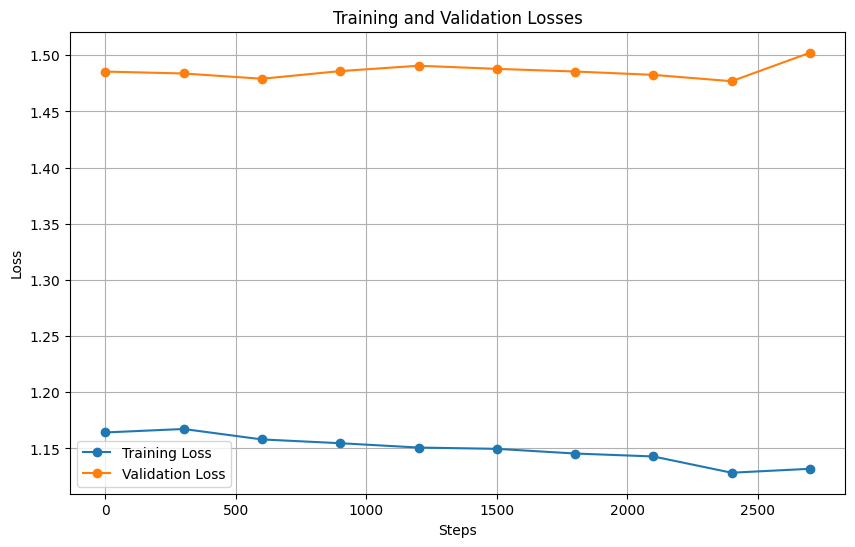

In [42]:
import matplotlib.pyplot as plt
import numpy as np

steps = list(np.arange(0, 3000, 300))

plt.figure(figsize=(10, 6))
plt.plot(steps, model.history['train'], marker='o')
plt.plot(steps, model.history['val'], marker='o')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title("Training and Validation Losses")
plt.grid(True)
plt.show()